In [1]:
import copy
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
from collections import namedtuple

# 1. Maze Generation

In [2]:
#Generates a k*k grid, X, represented by a numpy array with p-percent of cells being lava.
#Here, X[i,j] == 1 means the cell is safe, and X[i,j] == 0 means it is lava.
#The start cell (0,0) and the end cell (n-1,n-1) are never lava.
def gen_maze(n,p):
    X = np.array([0]*int(np.floor(n**2 * p)) + [1]*int(np.ceil(n**2 * (1-p))),dtype=np.int64)
    np.random.shuffle(X)
    X[0] = 1  #start at top left corner
    X[-1] = 1 #goal at bottom right corner
    X = X.reshape((n, n))
    return X

In [3]:
#A finite-horizon, tabular MDP is described by a named-tuple with the usual interpretations.
MDP = namedtuple('MDP', 'S A P r H s0')

In [4]:
#Create the maze shortest-path MDP as defined in the experiment's section from a given grid X 
#and a given time-horizon H
def load_maze_mdp(X,H):
    n = len(X)
    A = np.array(range(5)) #S, L, R, U, D respectively.
    S = np.array(range(int(n**2))) #Each state represents a cell (i,j) in row-major order.
    P = np.zeros((H,len(S),len(A),len(S)))
    r = np.zeros((H,len(S), len(A)))
    for h in range(H):
        for s in S:
            i = int(s // n) #the row of the cell
            j = int(s - i*n) #the column of the cell
            P[h,s,0,s] = 1 #Transition for S
            if i == (n-1) and j == (n-1):
                    r[h,s,0] = 1 #Reward for staying at Goal
            if j - 1 >= 0:
                P[h,s,1,i*n + j-1] = 1 #Transition for L
                if X[i,j-1] == 0: 
                    r[h,s,1] = -H #Reward for entering Lava
            if j + 1 < n:
                P[h,s,2, i*n + j+1] = 1 #Transition for R
                if i == (n-1) and j + 1 == (n-1):
                    r[h,s,2] = 1 #Reward for entering the Goal
                if X[i,j+1] == 0:
                    r[h,s,2] = -H #Reward for entering Lava
            if i - 1 >= 0:
                P[h,s,3,(i-1)*n + j] = 1 #Transition for U
                if X[i-1,j] == 0: 
                    r[h,s,3] = -H #Reward for entering Lava
            if i + 1 < n:
                P[h,s,4,(i+1)*n + j] = 1 #Transition for D
                r[h,s,4] = 0
                if i + 1 == (n-1) and j == (n-1):
                    r[h,s,4] = 1 #Reward for entering the Goal
                if X[i+1,j] == 0: 
                    r[h,s,4] = -H #Reward for entering Lava
    s0 = 0 #start at (0,0)
    M = MDP(S,A,P,r,H,s0)
    return M

# 2. No Attack

In [5]:
#Example maze as described in the Experiment Section
X = np.array([[1, 1, 1, 1, 1, 1, 0, 1, 0, 1],
       [1, 1, 0, 1, 1, 1, 1, 1, 1, 0],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 1, 1, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 0, 1, 1, 1]])
H = 2*len(X)
M = load_maze_mdp(X,H)

In [6]:
#get optimal value and optimal policy for MDP M
def get_opt(M):
    V = np.zeros((M.H, len(M.S)))
    pi = np.zeros((M.H, len(M.S)))
    for s in M.S:
        V[M.H-1] = np.max(M.r[M.H-1],axis=1)
        pi[M.H-1] = np.argmax(M.r[M.H-1],axis=1)
    for h in range(M.H-2,-1,-1):
        for s in M.S:
            V[h] = np.max(M.r[h] + M.P[h] @ V[h+1],axis=1)
            pi[h] = np.argmax(M.r[h] + M.P[h] @ V[h+1],axis=1)
    return V[0,M.s0],pi.astype(int)

### 2.1 Optimal Value under No Attack

In [7]:
V, pi = get_opt(M)
print(V)

3.0


In [8]:
#trace the trajectory of the agent following pi in the maze M
def get_path(M,pi):
    s = M.s0
    n = int(np.sqrt(len(M.S)))
    path = [(0,0)]
    for h in range(M.H):
        s = np.argmax(M.P[h,s,pi[h,s]])
        i = int(s // n)
        j = int(s - i*n)
        path.append((i,j))
    return path

In [9]:
#visualize the path on the grid X and save to file
def print_path(X, path, filename):
    Y = copy.deepcopy(X)
    for (i,j) in path:
        Y[i,j] = -1
    plt.matshow(Y, cmap=plt.get_cmap('hot'))
    plt.savefig(filename, dpi=300, bbox_inches = "tight")

## 2.2 Optimal Path under No Attack

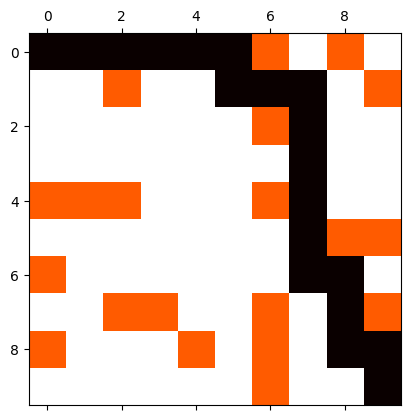

In [10]:
path = get_path(M,pi)
print_path(X,path, 'clean')

## 3. Experiment: State Attack

In [11]:
#state attack meta-MDP
def state_mdp(M, pi, B):
    mS = M.S
    mA = M.S
    mP = np.zeros((M.H,len(M.S),len(M.S),len(M.S)))
    mr = np.zeros((M.H,len(M.S), len(M.S)))
    for h in range(M.H):
        for s in mS:
            for sp in mS:
                for s_dag in mA:
                    mP[h,s, s_dag, sp] = M.P[h,s_dag,pi[h,s_dag],sp]
    for h in range(M.H):
        for s in mS:
            for s_dag in mA:
                if s_dag in B[h,s]:
                    mr[h,s,s_dag] = -M.r[h,s_dag,pi[h,s_dag]]
                else:
                    mr[h,s,s_dag] = -np.infty
    mM = MDP(mS, mA, mP, mr, M.H, M.s0)
    return mM

In [12]:
#The constraint set for state-based attacks as described in the Experiment Section
Bs = {(h,s): [s] for h in range(M.H) for s in M.S}
n = int(np.sqrt(len(M.S)))
for h in range(M.H):
    for i in range(0,2):
        for j in range(7,n):
            Bs[h,int(i*n + j)] = M.S

## 3.1 Victim's Value under Optimal Attack

In [13]:
Ms = state_mdp(M,pi,Bs)
Vs, nus = get_opt(Ms)
print(-Vs)

-0.0


In [14]:
def state_path(M, pi, nu):
    path = [(0,0)]
    i = 0
    j = 0
    n = int(np.sqrt(len(M.S)))
    s = M.s0
    for h in range(M.H):
        s_p = nu[h,s]
        s = np.argmax(M.P[h,s_p,pi[h,s_p]])
        i = int(s//n)
        j = s - i*n
        path += [(i,j)]
    return path

## 3.2 Victim's Path under Optimal Attack

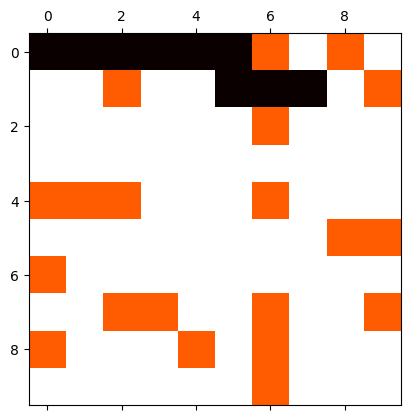

In [15]:
poison = state_path(M, pi, nus)
print_path(X,poison,'state_attack')

## 4. Experiment: Perceived-State Attack

In [16]:
#perceived-state attack meta-MDP
def perceived_mdp(M, pi, B):
    mS = M.S
    mA = M.S
    mP = np.zeros((M.H,len(M.S),len(M.S),len(M.S)))
    mr = np.zeros((M.H,len(M.S), len(M.S)))
    for h in range(M.H):
        for s in mS:
            for sp in mS:
                for s_dag in mA:
                    mP[h,s, s_dag, sp] = M.P[h,s,pi[h,s_dag],sp]
    for h in range(M.H):
        for s in mS:
            for s_dag in mA:
                if s_dag in B[h,s]:
                    mr[h,s,s_dag] = -M.r[h,s,pi[h,s_dag]]
                else:
                    mr[h,s,s_dag] = -np.infty
    mM = MDP(mS, mA, mP, mr, M.H, M.s0)
    return mM

## 4.1 Victim's Value under Optimal Attack

In [17]:
Mp = perceived_mdp(M,pi,Bs)
Vp,nup = get_opt(Mp)
print(-Vp)

-100.0


In [18]:
def perceived_path(M, pi, nu):
    path = [(0,0)]
    i = 0
    j = 0
    n = int(np.sqrt(len(M.S)))
    s = M.s0
    for h in range(M.H):
        s_p = nu[h,s]
        s = np.argmax(M.P[h,s,pi[h,s_p]])
        i = int(s // n)
        j = s - i*n
        path += [(i,j)]
    return path

## 4.2 Victim's Path under Optimal Attack

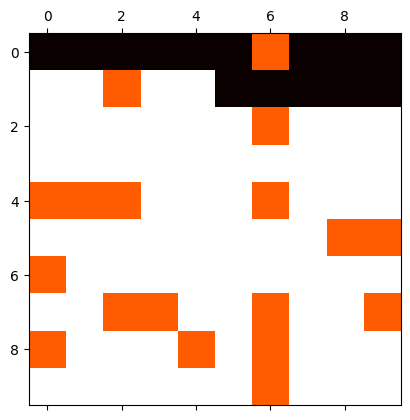

In [19]:
poison = perceived_path(M, pi, nup)
print_path(X,poison,'perceived_attack')

## 5. Experiment: Action Attack

In [20]:
#action attack MDP
def action_mdp(M, pi, B):
    mS = M.S
    mA = M.A
    mP = np.zeros((M.H,len(M.S),len(M.A),len(M.S)))
    mr = np.zeros((M.H,len(M.S), len(M.A)))
    for h in range(M.H):
        for s in mS:
            for sp in mS:
                for a_dag in mA:
                    mP[h,s, a_dag, sp] = M.P[h,s,a_dag,sp]
    for h in range(M.H):
        for s in mS:
            for a_dag in mA:
                if a_dag in B[h,s,pi[h,s]]:
                    mr[h,s,a_dag] = -M.r[h,s,a_dag]
                else:
                    mr[h,s,a_dag] = -np.infty
    mM = MDP(mS, mA, mP, mr, M.H, M.s0)
    return mM

In [21]:
#constraint set for action attacks
Ba = {(h,s,a): [a] for h in range(M.H) for s in M.S for a in M.A}
n = int(np.sqrt(len(M.S)))
for h in range(M.H):
    for i in range(0,5):
        for j in range(5,n):
            for a in M.A:
                Ba[h,int(i*n + j),a] = M.A

## 5.1 Victim's Value under Optimal Attack

In [22]:
Ma = action_mdp(M,pi,Ba)
Va, nua = get_opt(Ma)
print(-Va)

-160.0


In [23]:
def action_path(M, pi, nu):
    path = [(0,0)]
    i = 0
    j = 0
    n = int(np.sqrt(len(M.S)))
    s = M.s0
    for h in range(M.H):
        a = nu[h,s]
        s = np.argmax(M.P[h,s,a])
        i = int(s // n)
        j = s - i * n
        path += [(i,j)]
    return path

## 5.2 Victim's Path under Optimal Attack

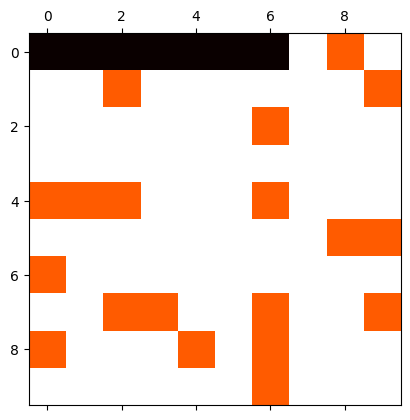

In [24]:
poison = action_path(M, pi, nua)
print_path(X,poison,'action_attack')

# 6. Experiment: Defense

In [25]:
#get optimal defense value and optimal defense policy using the maximin recursion for adversarial attacker's
def action_defense(M, B):
    V = {} 
    pi = {} 
    for s in M.S:
        cur = {a: min({a_dag: M.r[M.H-1,s,a_dag] for a_dag in B[M.H-1,s,a]}.values()) for a in M.A}
        V[M.H-1, s] = max(cur.values())
        pi[M.H-1, s] = max(cur, key = cur.get)
    for h in range(M.H-2,-1,-1):
        for s in M.S:
            cur = {a: min({a_dag: (M.r[h,s,a_dag] + sum([M.P[h,s,a_dag,s_p]*V[h+1,s_p] for s_p in M.S])) 
                           for a_dag in B[h,s,a]}.values()) for a in M.A}
            V[h,s] = max(cur.values())
            pi[h,s] = max(cur, key = cur.get)
    return V[0,M.s0],pi

## 6.1 Victim's Robust Value under No Attack

In [26]:
Vd, pid = action_defense(M,Ba)
print(Vd)

3.0


## 6.2 Victim's Robust Path under No Attack

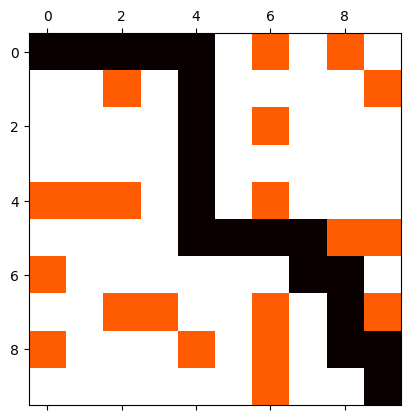

In [27]:
path = get_path(M,pid)
print_path(X,path, 'clean_defense')

## 6.3 Victim's Robust Value under Optimal Attack

In [28]:
Mad = action_mdp(M,pid,Ba)
Vad, nuad = get_opt(Mad)
print(-Vad)

3.0


## 6.4 Victim's Robust Path under Optimal Attack

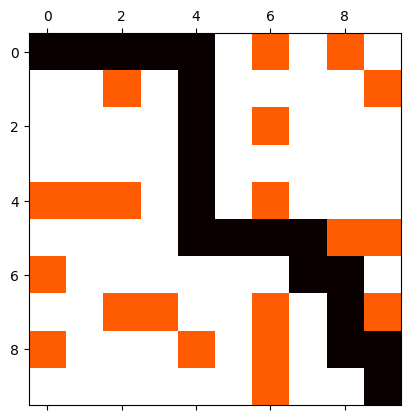

In [29]:
poison = action_path(M, pid, nuad)
print_path(X,poison,'action_defense')

# Full meta-MDP Construction

In [30]:
#Complete meta-MDP
def meta_mdp(M,pi,B):
    mH = 4*M.H
    ms0 = M.s0
    mS = {}
    mA = {}
    for mh in range(mH):
        h = int(mh/4)
        if mh % 4 == 0:
            mS[mh] = M.S[h]
        elif mh % 4 == 1:
            mS[mh] = [(s,M.O[s]) for s in M.S[h]]
        elif mh % 4 == 2:
            mS[mh] = [(s,s_d,a) for s in M.S[h] for s_d in M.S[h] for a in M.A[h,s_d]]
        elif mh % 4 == 3:
            mS[mh] = [(s,s_d,a,M.r[h,s,a]) for s in M.S[h] for s_d in M.S[h] for a in M.A[h,s_d]]
    for mh in range(mH):
        for ms in mS[mh]:
            h = int(mh/4)
            if mh % 4 == 0:
                mA[mh] = B[h,ms]
            elif mh % 4 == 1:
                mA[mh] = B[h,ms[0],ms[1]]
            elif mh % 4 == 2:
                mA[mh] = B[h,ms[0],ms[1],ms[2]]
            elif mh % 4 == 3:
                mA[mh] = B[h,ms[0],ms[1],ms[2],ms[3]]
    mP = {}
    for mh in range(mH):
        for ms in mS[mh]:
            for ma in mA[mh,ms]:
                h = int(mh/4)
                if mh % 4 == 0:
                    mP[mh,ms,ma] = (ma,M.O[ma])
                elif mh % 4 == 1:
                    mP[mh,ms,ma] = (ms[0],ma,pi[ma])
                elif mh % 4 == 2:
                    mP[mh,ms,ma] = (ms[0],ms[1],ma,M.r[h,ms[0],ma])
                elif mh % 4 == 3:
                    mP[mh,ms,ma] = M.P[h,ms[0],ms[2]]
    mr = {}
    for mh in range(mH):
        for ms in mS[mh]:
            for ma in mA[mh,ms]:
                h = int(mh/4)
                if mh % 4 == 3:
                    mr[mh,ms,ma] = ma
                else:
                    mr[mh,ms,ma] = 0
    mM = MDP(mS, mA, mP, mr, mH, ms0)
    return mM